In [1]:
import os
import sys
import glob
import numpy as np
from tqdm import trange
from astropy.io import fits
from astropy.table import Table, vstack
from astropy.convolution import convolve, Gaussian1DKernel
import astropy.units as u
import astropy.coordinates as coord
import matplotlib
import matplotlib.pyplot as plt
from astropy.table import Column
from tqdm import trange
import pandas as pd
import fitsio
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from easyquery import Query, QueryMaker
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap, BoundaryNorm
import h5py
from astropy.cosmology import Planck18
import glob
from matplotlib.lines import Line2D

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

rootdir = '/global/u1/v/virajvm/'
sys.path.append(os.path.join(rootdir, 'DESI2_LOWZ/desi_dwarfs/code'))

from desi_lowz_funcs import make_subplots, match_c_to_catalog, print_radecs
from desi_lowz_funcs import calc_normalized_dist
from desi_lowz_funcs import find_objects_nearby
from construct_dwarf_galaxy_catalogs import process_sga_matches


### Plot 1: Make a cumulative distribution of objects as a function of FRACFLUX in the 3 bands

Make a random sweep in the sky?? 

And then also a plot focusing on the DESI DR1 dataset?

In [3]:
all_sweeps = glob.glob("/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/south/sweep/9.0/sweep-150*")

In [4]:
all_fracflux_g = []
all_fracflux_r = []
all_fracflux_z = []


for i in trange(len(all_sweeps)):

    sweep_data = fits.open(all_sweeps[i])
    sweep_data = sweep_data[1].data

    sweep_data = sweep_data[ sweep_data["TYPE"]  != "PSF" ]
        
    fracflux_g = sweep_data["FRACFLUX_G"]
    fracflux_r = sweep_data["FRACFLUX_R"]
    fracflux_z = sweep_data["FRACFLUX_Z"]

    all_fracflux_g.append(fracflux_g)
    all_fracflux_r.append(fracflux_r)
    all_fracflux_z.append(fracflux_z)


all_fracflux_g = np.concatenate(all_fracflux_g)
all_fracflux_r = np.concatenate(all_fracflux_r)
all_fracflux_z = np.concatenate(all_fracflux_z)



100%|██████████| 15/15 [02:24<00:00,  9.61s/it]


In [5]:
all_fracflux = np.concatenate( [all_fracflux_g, all_fracflux_r, all_fracflux_z] )

In [ ]:
plt.figure(figsize = (5,5))
plt.title("All DR9 Sources",fontsize = 15)
plt.hist(all_fracflux, cumulative=-1,range=(0,1.5),bins=1000,density=True,histtype = "step",lw =4,color = "k",zorder=1)
plt.xlim([0,1.5])
plt.ylim([5e-3,1])
plt.vlines(x = 0.2,ymin=5e-3, ymax=1,color = "grey",lw = 2, alpha = 0.35,zorder=0)
plt.yscale("log")
plt.xlabel(r"FRACFLUX$\_$G/R/Z", fontsize=15)
plt.ylabel(r"$n$($\geq$FRACFLUX)",fontsize = 15)
# plt.grid(ls = ":", color = "lightgrey")
plt.savefig("plots/all_dr9_fracflux.pdf",bbox_inches="tight")
plt.show()

Make the same plot, but for confident sources in DESI DR1

In [6]:
save_folder = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs"

save_filenames = {"BGS_BRIGHT":  "iron_bgs_bright_filter_zsucc_zrr02_allfracflux.fits", 
                  "BGS_FAINT": "iron_bgs_faint_filter_zsucc_zrr03_allfracflux.fits",
                   "LOWZ":  "iron_lowz_filter_zsucc_zrr03.fits" ,
                   "ELG": "iron_elg_filter_zsucc_zrr05_allfracflux.fits"}


In [7]:
def get_fracflux_vals(path = save_folder + "/" + save_filenames["BGS_BRIGHT"], combine=True, dwarf_mask=False,zred_mask=None):
    
    cat = Table.read(path)

    print(len(cat))
    
    cat_other = Table.read(path.replace(".fits","_W_SGA.fits"))

    cat = vstack([cat, cat_other])

    print(len(cat))

    if dwarf_mask:
        dwd_mask = (cat["LOGM_SAGA"] < 9.25)
        cat = cat[dwd_mask]

    if zred_mask is not None:
        zred_mask = (cat["Z"] < zred_mask)
        cat = cat[zred_mask]
    
    ff_g = cat["FRACFLUX_G"].data
    ff_r = cat["FRACFLUX_R"].data
    ff_z = cat["FRACFLUX_Z"].data

    if combine:
        all_ff = np.concatenate([ff_g, ff_r, ff_z])
        return all_ff
    else:
        return ff_g, ff_r, ff_z

    

In [8]:
bgsb_ff = get_fracflux_vals(save_folder + "/" + save_filenames["BGS_BRIGHT"], combine=True)
bgsf_ff = get_fracflux_vals(save_folder + "/" + save_filenames["BGS_FAINT"], combine=True)
elg_ff = get_fracflux_vals(save_folder + "/" + save_filenames["ELG"], combine=True)


2076537
2185342
985317
986399
145301
145301


In [9]:
bgsb_z01_ff = get_fracflux_vals(save_folder + "/" + save_filenames["BGS_BRIGHT"], combine=True,dwarf_mask=False,zred_mask=0.01)
bgsf_z01_ff = get_fracflux_vals(save_folder + "/" + save_filenames["BGS_FAINT"], combine=True,dwarf_mask=False,zred_mask=0.01)
elg_z01_ff = get_fracflux_vals(save_folder + "/" + save_filenames["ELG"], combine=True,dwarf_mask=False,zred_mask=0.01)

bgsb_z1_ff = get_fracflux_vals(save_folder + "/" + save_filenames["BGS_BRIGHT"], combine=True,dwarf_mask=False,zred_mask=0.1)
bgsf_z1_ff = get_fracflux_vals(save_folder + "/" + save_filenames["BGS_FAINT"], combine=True,dwarf_mask=False,zred_mask=0.1)




2076537
2185342
985317
986399
145301
145301
2076537
2185342
985317
986399


In [10]:
elg_z1_ff = get_fracflux_vals(save_folder + "/" + save_filenames["ELG"], combine=True,dwarf_mask=False,zred_mask=0.1)


145301
145301


In [11]:
sample_color_map = {"BGS_BRIGHT" : "#882255", "BGS_FAINT": "#CC6677", "LOWZ":"#DDCC77", "ELG": "#88CCEE" }


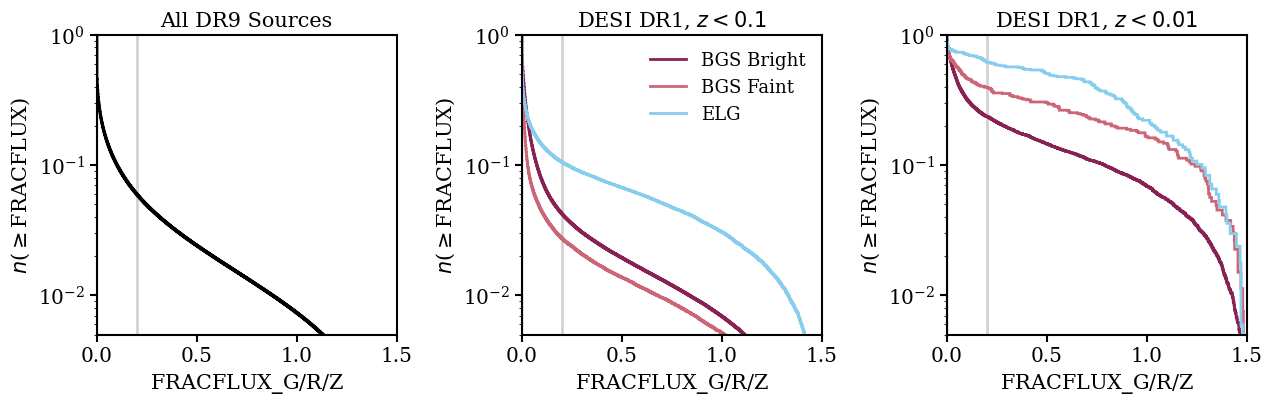

In [12]:
fig,ax = make_subplots(ncol = 3, nrow =1,return_fig=True,col_spacing=1.25)

ax[0].set_title("All DR9 Sources",fontsize = 15)

# for i in range(3):
ax[0].hist(all_fracflux, cumulative=-1,range=(0,1.5),bins=1000,density=True,histtype = "step",lw =2,color = "k",zorder=1)

ax[1].set_title("DESI DR1, $z < 0.1$",fontsize = 15)
ax[1].hist(bgsb_z1_ff, cumulative=-1,range=(0,1.5),bins=1000,density=True,histtype = "step",lw =2,color = sample_color_map["BGS_BRIGHT"],ls = "-",label = "BGS Bright")
ax[1].hist(bgsf_z1_ff, cumulative=-1,range=(0,1.5),bins=1000,density=True,histtype = "step",lw =2,color = sample_color_map["BGS_FAINT"],ls = "-", label = "BGS Faint")
ax[1].hist(elg_z1_ff, cumulative=-1,range=(0,1.5),bins=1000,density=True,histtype = "step",lw =2,color = sample_color_map["ELG"],ls = "-",label = "ELG")

ax[2].set_title("DESI DR1, $z < 0.01$",fontsize = 15)
ax[2].hist(bgsb_z01_ff, cumulative=-1,range=(0,1.5),bins=1000,density=True,histtype = "step",lw =2,color = sample_color_map["BGS_BRIGHT"],ls = "-")
ax[2].hist(bgsf_z01_ff, cumulative=-1,range=(0,1.5),bins=1000,density=True,histtype = "step",lw =2,color =  sample_color_map["BGS_FAINT"],ls = "-")
ax[2].hist(elg_z01_ff, cumulative=-1,range=(0,1.5),bins=1000,density=True,histtype = "step",lw =2,color =  sample_color_map["ELG"],ls = "-")

# Custom legend lines
custom_lines = [
    Line2D([0], [0], color= sample_color_map["BGS_BRIGHT"], lw=2, label='BGS Bright'),
    Line2D([0], [0], color= sample_color_map["BGS_FAINT"], lw=2, label='BGS Faint'),
    Line2D([0], [0], color= sample_color_map["ELG"], lw=2, label='ELG')
]

ax[1].legend(frameon=False,loc="upper right",fontsize = 13,handles=custom_lines)


for i in range(3):
    ax[i].set_xlim([0,1.5])
    ax[i].set_ylim([5e-3,1])
    ax[i].vlines(x = 0.2,ymin=5e-3, ymax=1,color = "grey",lw = 2, alpha = 0.35,zorder=0)
    ax[i].set_yscale("log")
    ax[i].set_xlabel(r"FRACFLUX$\_$G/R/Z", fontsize=15)
    ax[i].set_ylabel(r"$n$($\geq$FRACFLUX)",fontsize = 15)

plt.savefig("plots/desi_fracflux.pdf",bbox_inches="tight")
plt.show()

In [ ]:
x0, y0 = 0.0, 8.0
x1, y1 = 0.0125, 1.53
slope = (y1 - y0) / (x1 - x0)
intercept = y0  # Since x0 = 0

In [ ]:
slope

In [ ]:
intercept

## Plot 2: Make a plot show casing candidate dwarf galaxies as a function fracflux and magnitude?

In [295]:
# save_folder = "/pscratch/sd/v/virajvm/catalog_dr1_dwarfs"
shred_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_shreds_catalog_v4.fits")


In [347]:
clean_cat = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/desi_y1_dwarf_clean_catalog_v4.fits")


In [353]:
## we select the first 10k clean objects in each sample?
clean_lowz = clean_cat[clean_cat["SAMPLE"] == "LOWZ"][:10000]
clean_elg = clean_cat[clean_cat["SAMPLE"] == "ELG"][:10000]
clean_bgsb = clean_cat[clean_cat["SAMPLE"] == "BGS_BRIGHT"][:10000]
clean_bgsf = clean_cat[clean_cat["SAMPLE"] == "BGS_FAINT"][:10000]



Show example panel of dwarfs!

In [741]:
sga_shred = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_SGA_sga_catalog_w_aper_mags.fits")
bgsb_shred = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
elg_shred = Table.read("/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")


In [762]:
sga_obj = sga_shred[(sga_shred["Z"] < 0.01) & (sga_shred["Z"] > 0.002) & (sga_shred["LOGM_SAGA_APERTURE_COG"] < 8) & (sga_shred["LOGM_SAGA_APERTURE_COG"] > 6) & (sga_shred["FRACFLUX_G"] > 0.35) & (sga_shred["FRACFLUX_R"] > 0.35) & (sga_shred["FRACFLUX_Z"] > 0.35) ][:100]
bgsb_obj = bgsb_shred[(bgsb_shred["Z"] < 0.01) & (bgsb_shred["Z"] > 0.002) & (bgsb_shred["LOGM_SAGA_APERTURE_COG"] < 8) & (bgsb_shred["LOGM_SAGA_APERTURE_COG"] > 6) & (bgsb_shred["FRACFLUX_G"] > 0.35) & (bgsb_shred["FRACFLUX_R"] > 0.35) & (bgsb_shred["FRACFLUX_Z"] > 0.35) ][:100]
elg_obj = elg_shred[(elg_shred["Z"] < 0.01) & (elg_shred["Z"] > 0.002) & (elg_shred["LOGM_SAGA_APERTURE_COG"] < 8) & (elg_shred["LOGM_SAGA_APERTURE_COG"] > 6) & (elg_shred["FRACFLUX_G"] > 0.35) & (elg_shred["FRACFLUX_R"] > 0.35) & (elg_shred["FRACFLUX_Z"] > 0.35) ][:100]


In [802]:
def plot_example_dwarfs(ax, catalog, idx, scale_f = 8):
    
    file_path = catalog["FILE_PATH"][idx]
    img_path = catalog["IMAGE_PATH"][idx]
    tgid = catalog["TARGETID"][idx]
    # img_path = catalog["IMAGE_PATH"][idx]

    max_axis = int(scale_f * catalog["COG_APER_PARAMS"][:,0][idx])

    
    reconst = np.load(file_path + "/final_reconstruct_galaxy.npy")
    # reconst_img = sdss_rgb(reconst)

    ##get the tractor source model
    source_model = np.load(file_path + "/tractor_source_model.npy")
    # source_img = sdss_rgb(source_model)

    # maybe show the Tractor Model?
    # total_model = 

    #get image and wcs infno
    img_path = catalog[idx]["IMAGE_PATH"]
    hdus = fits.open(img_path)
    img_data = hdus[0].data
    wcs = WCS(fits.getheader( img_path))
    # rgb_img=sdss_rgb(img_data)

    rgb_img, shift = process_img(img_data, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    source_img, _ = process_img(source_model, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    reconst_img, _ = process_img(reconst, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    # model_img, _ = process_img(  )


    #at bottom, show the RA,DEC of this cutout  
    ax[0].set_title(f"TARGETID = {tgid}",fontsize = 12)
    ax[0].imshow(rgb_img, origin='lower')

    ax[1].imshow(source_img, origin="lower")

    fsize = 13
    fs_col = "white"
    yloc = 0.95
    
    # ax[1].set_title("DESI Source Tractor Model",fontsize = fsize)
    #top show the grz magnitudes of these objects
    # ax[1].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_org, r_org, z_org),size = fsize,
    #            transform=ax[0].transAxes, va='top',ha="center",color = fs_col)

    # ax[0].set_ylabel(f"{targetid}",fontsize = 13)
    
    ax[2].imshow(reconst_img, origin="lower")
    ax[2].set_title("This Method",fontsize = fsize)
    # ax[2].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_new, r_new, z_new),size = fsize,
    #            transform=ax[1].transAxes, va='top',ha="center",color = fs_col)
    


    for axi in ax:
        axi.set_xticks([])
        axi.set_yticks([])

    #plot the horizontal bar plotting 30''
    fs=12
    bar_size = 30/0.262
    bar_start = 0.07*np.shape(rgb_img)[0]
    y_bar = 0.07*np.shape(rgb_img)[0]
    
    for i in range(3):
        ax[i].plot([bar_start, bar_start+bar_size], [y_bar,y_bar],color = "white",lw = 1)
        
    # ax[0].text( bar_start + 0.4*bar_size, y_bar*1.15, r"$30''$",fontsize = fs,color = "white"  )
            
    return ax

from desi_lowz_funcs import get_scrollable_pdfs

    

These are the tgids to show:

SGA: 39627894116324358, 39627894120518881, 39627666898293590, 39633005240650807, 39633262703807751, 39632935762002978

BGSB: 39627631053769626, 39627628562350654, 39627636309230897, 39627643653460508, 39627642944618581, 39627666902485913, 39627703506176030, 39627737085772411, 39627740013401179, 39627745596016246, 39627752084603161, 
39627790391187481, 39627787199317731

ELG: 39627250441655304, 39627329424596254, 39627335137233103, 39627473968696018, 39627636309230868, 39627667204478532, 39627703434872703, 39627751577095192, 39627752143328976, 39627757478481897, 
39627757658834857, 39627769868452521, 39627799736093145, 39627836151038877, 39628377929290386, 39633034751772232

In [811]:

all_files = []
for idx in range(35):
    ax = make_subplots(ncol = 3, nrow = 1,col_spacing = 0.05)
    plot_example_dwarfs(ax, elg_obj, idx)
    plt.savefig(f"/pscratch/sd/v/virajvm/trash/elg_dwarfs_near/elg_dwarf_{idx}.png",bbox_inches="tight")
    all_files.append(f"/pscratch/sd/v/virajvm/trash/elg_dwarfs_near/elg_dwarf_{idx}.png" )
    plt.close()

get_scrollable_pdfs(all_files, "/pscratch/sd/v/virajvm/trash/elg_nearby_dwarf_egs.pdf")

Scrollable pdf saved at /pscratch/sd/v/virajvm/trash/elg_nearby_dwarf_egs.pdf


In [825]:

def save_full_model_cutouts(ra,dec,img_path,session, size=350, timeout = 30):
    url_prefix = 'https://www.legacysurvey.org/viewer/'
    
    url = url_prefix + f'cutout.fits?ra={ra}&dec={dec}&size=%s&'%size

    url += 'layer=ls-dr9-model&pixscale=0.262&bands=grz'

    try:
        resp = session.get(url, timeout=timeout)
        resp.raise_for_status()  # Raise error for bad status codes
        # Save the FITS file
        with open(img_path, "wb") as f:
            f.write(resp.content)
    
        #load the wcs and image data
        # img_data = fits.open(img_path)
        # data_arr = img_data[0].data
        # wcs = WCS(fits.getheader( img_path ))
    except:
        print("getting coadd image data failed!")
        print(url)
    
    return

In [998]:

import requests

session = requests.Session()

def make_one_panel_dwarf(ax, catalog, tgid,scale_f=5,get_model=False,savefig=False,bar_size_arc = 30):

    idx = np.where( catalog["TARGETID"] == tgid )[0][0]

    print(tgid)
    
    file_path = catalog["FILE_PATH"][idx]
    img_path = catalog["IMAGE_PATH"][idx]

    ra,dec = catalog["RA"][idx], catalog["DEC"][idx]

    zred = catalog["Z"][idx]

    #get the source photometry, 
    g_old, r_old, z_old = catalog["MAG_G"][idx], catalog["MAG_R"][idx], catalog["MAG_Z"][idx]
    g_new, r_new, z_new = catalog["MAG_G_APERTURE_COG"][idx], catalog["MAG_R_APERTURE_COG"][idx], catalog["MAG_Z_APERTURE_COG"][idx]

    #choose the size of the image?
    max_axis = np.maximum( int(scale_f * catalog["COG_APER_PARAMS"][:,0][idx]), 115 )

    reconst = np.load(file_path + "/final_reconstruct_galaxy.npy")

    ##get the tractor source model
    source_model = np.load(file_path + "/tractor_source_model.npy")

    #get image and wcs infno
    img_path = catalog[idx]["IMAGE_PATH"]
    hdus = fits.open(img_path)
    img_data = hdus[0].data
    wcs = WCS(fits.getheader( img_path))


    # maybe show the Tractor Model?
    #get the
    full_model_path = f"/pscratch/sd/v/virajvm/trash/full_dwarf_tractor_models/trac_model_{tgid}.fits"

    if get_model:
        if os.path.exists(full_model_path) == False:
            save_full_model_cutouts(ra,dec,full_model_path,session, size=max_axis, timeout = 30)
        
        #read in the model
        full_model = fits.open(full_model_path)[0].data
    else:
        full_model = np.ones_like(img_data)
    
    print(img_data.shape)
    print(full_model.shape)

    rgb_img, shift = process_img(img_data, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    source_img, _ = process_img(source_model, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    reconst_img, _ = process_img(reconst, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    model_img, _ = process_img(full_model,  cutout_size = max_axis, org_size = np.shape(full_model)[1], return_shift=True   )


    fsize = 13
    fs_col = "white"
    yloc = 0.95

    #at bottom, show the RA,DEC of this cutout  
    # ax[0].set_title(f"TARGETID = {tgid}",fontsize = 12)
    ax[3].imshow(rgb_img, origin='lower')
    ax[3].text(0.5,yloc,r"%d, $z$ = %.3f"%(tgid, zred),size = fsize-1,
               transform=ax[3].transAxes, va='top',ha="center",color = fs_col,zorder = 1)
    
    ax[2].imshow(model_img, origin="lower")

    print(g_old, g_new)

    
    ax[1].imshow(source_img, origin="lower",zorder = 0)
        #top show the grz magnitudes of these objects
    ax[1].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_old, r_old, z_old),size = fsize,
               transform=ax[1].transAxes, va='top',ha="center",color = fs_col,zorder = 1)


    # ax[0].set_ylabel(f"{targetid}",fontsize = 13)
    
    ax[0].imshow(reconst_img, origin="lower")
    ax[0].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_new, r_new, z_new),size = fsize,
               transform=ax[0].transAxes, va='top',ha="center",color = fs_col)
    
    for axi in ax:
        axi.set_xticks([])
        axi.set_yticks([])

    #plot the horizontal bar plotting 30''
    fs=12
    bar_size = bar_size_arc/0.262
    bar_start = 0.07*np.shape(rgb_img)[0]
    y_bar = 0.07*np.shape(rgb_img)[0]
    
    for i in range(4):
        ax[i].plot([bar_start, bar_start+bar_size], [y_bar,y_bar],color = "white",lw = 1)
        
    ax[3].text( bar_start + 0.5*bar_size, y_bar*1.15, f"{bar_size_arc:d}''",fontsize = fs,color = "white", ha='center')

    ##let us draw a circle indicating the DESI fiber
    # circle_2 = patches.Circle( (fiber_xpix, fiber_ypix),3, color='orange', fill=False, linewidth=1,ls ="--")    
    # ax[ax_id].add_patch(circle)

    if savefig:
        plt.savefig(f"/pscratch/sd/v/virajvm/trash/dwarf_final_images/model_{tgid}.png",bbox_inches="tight",dpi=150)

    plt.show()
        
    return

    
    
    

In [969]:
# elg_obj[elg_obj["TARGETID"] == 39627329424596254]["FILE_PATH"]

In [1029]:
# sga_dwarfs = [39627894116324358, 39627894120518881, 39627666898293590, 39633005240650807, 39633262703807751, 39632935762002978]
# sga_scale_sizes = [5, 7,8, 7, 7,9]

# print(len(sga_dwarfs), len(sga_scale_sizes) )

# bgsb_dwarfs = [39627631053769626, 39627628562350654, 39627636309230897, 39627643653460508, 39627642944618581, 39627666902485913, 39627703506176030, 39627737085772411, 39627740013401179, 39627745596016246, 39627752084603161, 39627790391187481, 39627787199317731]
# bgsb_scale_sizes = [7, 7, 10, 7, 5, 6,   7, 6, 7, 7, 8, 7, 6 ]

# print(len(bgsb_dwarfs), len(bgsb_scale_sizes) )


# elg_dwarfs = [39627250441655304, 39627329424596254, 39627335137233103, 39627473968696018, 39627667204478532, 39627703434872703, 39627751577095192, 39627752143328976, 39627757478481897, 39627757658834857, 39627769868452521, 39627799736093145, 39627836151038877, 39628377929290386, 39633034751772232]
# elg_scale_sizes = [6, 6,11, 8, 9, 7, 7, 7, 10, 9, 8, 8, 9, 9,  13     ]

# print(len(elg_dwarfs), len(elg_scale_sizes ) )

# save_path = ""

# ax = make_subplots(ncol = 1, nrow = 4,row_spacing = 0.01)

# make_one_panel_dwarf(ax, sga_obj, sga_dwarfs[3], scale_f=7, get_model = True,savefig=True,bar_size_arc=30)


In [1005]:
elg_obj[elg_obj["TARGETID"] == 39627757658834857]["LOGM_SAGA_APERTURE_COG"]

7.858660461329413


In [837]:
fits.open("/pscratch/sd/v/virajvm/trash/full_dwarf_tractor_models/trac_model_39627894116324358.fits")[0].data.shape

(3, 277, 277)

In [344]:
shred_cat[shred_cat["TARGETID"]  == 39627957773276164]["FILE_PATH"]

/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-250p005-260p010/2531p070/ELG_tgid_39627957773276164


In [330]:
cat =Table.read("/pscratch/sd/v/virajvm/data_to_share/desi_y1_dwarf_combine_catalog.fits")
cat = cat[(cat["MAG_G_APERTURE_COG"] > 0) & (cat["LOGM_SAGA"] < 9)]

In [332]:
## let us do a final model comparison of some real dwarf galaxies??
print(len(cat))
cat[:2]

6128


TARGETID,SURVEY,PROGRAM,HEALPIX,TILEID_LIST,RA,DEC,Z,ZWARN,DELTACHI2,SPECTYPE,Z_RR,TSNR2_QSO,TSNR2_LYA,PHOTSYS,LS_ID,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,FIBERTOTFLUX_G,FIBERTOTFLUX_R,FIBERTOTFLUX_Z,FLUX_G,FLUX_R,FLUX_Z,FLUX_W1,FLUX_W2,FLUX_W3,FLUX_W4,FLUX_IVAR_G,FLUX_IVAR_R,FLUX_IVAR_Z,FLUX_IVAR_W1,FLUX_IVAR_W2,FLUX_IVAR_W3,FLUX_IVAR_W4,EBV,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,MW_TRANSMISSION_W1,MW_TRANSMISSION_W2,MW_TRANSMISSION_W3,MW_TRANSMISSION_W4,MAG_G_DR9,MAG_R_DR9,MAG_Z_DR9,MAG_W1,MAG_W2,MAG_G_ERR_DR9,MAG_R_ERR_DR9,MAG_Z_ERR_DR9,MAG_W1_ERR,MAG_W2_ERR,OBJID,BRICKNAME,SIGMA_G,FRACFLUX_G,RCHISQ_G,SIGMA_GOOD_G,SIGMA_R,FRACFLUX_R,RCHISQ_R,SIGMA_GOOD_R,SIGMA_Z,FRACFLUX_Z,RCHISQ_Z,SIGMA_GOOD_Z,SHAPE_R,SHAPE_R_ERR,MU_R,MU_R_ERR,SERSIC,SERSIC_IVAR,BA,TYPE,PHI,FIBERMAG_R,MASKBITS,LOGM_SAGA_DR9,LOGM_M24_DR9,SWEEP,is_south,STARFDIST,STARDIST_DEG,STARMAG,STAR_RADIUS_ARCSEC,STAR_RA,STAR_DEC,SAMPLE,SGA_ID_MATCH,SGA_D26_NORM_DIST,SGA_DIST_DEG,IMAGE_PATH,FILE_PATH,MAG_G_APERTURE_COG,MAG_R_APERTURE_COG,MAG_Z_APERTURE_COG,MAG_G_APERTURE_COG_ERR,MAG_R_APERTURE_COG_ERR,MAG_Z_APERTURE_COG_ERR,MAG_G_APERTURE_COG_PARAMS,MAG_R_APERTURE_COG_PARAMS,MAG_Z_APERTURE_COG_PARAMS,MAG_G_APERTURE_COG_PARAMS_ERR,MAG_R_APERTURE_COG_PARAMS_ERR,MAG_Z_APERTURE_COG_PARAMS_ERR,LOGM_SAGA_APERTURE_COG,PCNN_FRAGMENT,NEAREST_STAR_NORM_DIST,MAG_G_APERTURE_R4,MAG_R_APERTURE_R4,MAG_Z_APERTURE_R4,MAG_G,MAG_G_ERR,MAG_R,MAG_R_ERR,MAG_Z,MAG_Z_ERR,LOGM_SAGA,HALPHA_FLUX,HALPHA_FLUX_IVAR,SNR_B,SNR_R,SNR_Z,HALPHA_EW,HALPHA_EW_IVAR
int64,bytes7,bytes6,int32,bytes47,float64,float64,float64,int64,float64,bytes6,float64,float32,float32,bytes1,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,bytes8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes3,float32,float32,int16,float64,float64,bytes29,int64,float32,float32,float32,float32,float32,float32,bytes10,int64,float64,float64,bytes128,bytes128,float64,float64,float64,float64,float64,float64,float64[5],float64[5],float64[5],float64[5],float64[5],float64[5],float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32
2706108581937152,main,dark,26931,10861,168.63484569960207,-3.3467887408591914,0.02486159570570868,0,35570.82839960419,GALAXY,0.02486159570570868,29.829716,99.441154,S,9906620234664654,2.243706,2.3047788,2.0148559,2.4398184,2.5555544,2.3018913,6.8153043,6.612889,5.488966,2.5311546,5.311872,123.90379,208.32568,513.19836,149.19162,46.08262,2.7408285,0.63763714,0.00080994127,1.1896353e-05,0.0590024,0.83974326,0.8890044,0.9363091,0.9900507,0.993878,0.9986912,0.9995056,20.416286,20.449022,20.651274,21.491703,20.68688,0.00704047,0.013457553,0.029172285,0.25939998,0.25626844,2766,1686m032,129.65056,0.32071352,1.144704,129.65056,71.80709,0.36617112,1.1052047,71.80709,34.888184,0.34605572,1.2318453,34.888184,0.89048195,0.011529649,22.192598,0.031164743,2.2571757,55.43504,0.6227966,SER,12.771566,21.593428,0,7.123131458799458,7.322425360902161,sweep-160m005-170p000-pz.fits,1,99.0,99.0,99.0,99.0,99.0,99.0,LOWZ,240180,27.273684286056735,0.14335034811403216,/pscratch/sd/v/virajvm/redo_photometry_plots/all_good_cutouts/image_tgid_2706108581937152_ra_168.634846_dec_-3.346789.fits,/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-160m005-170p000/1686m032/LOWZ_tgid_2706108581937152,19.052196576572012,18.8511580283211,18.766448318838325,0.002981075979621098,0.0021177127271849758,0.004598586444933108,19.24183028129394 .. 3.951922973895934,18.978898251281812 .. 3.5477856912418426,18.837900210983303 .. 3.3146663768426246,0.002981075979621098

In [336]:
# fig,ax = make_subplots(ncol = 1, nrow = 6, return_fig=True,col_spacing=0.1,row_spacing=0.1)

# np.random.seed(42)

# j = 0

# ff_grid = [0, 0.5, 1, 2, 4, 6]

# rmag_cut = (shred_cat["MAG_R"] < rmags[j] +1) & (shred_cat["MAG_R"] > rmags[j] - 1)

# plot_ind = 5
# for fi in ff_grid:
#     ff_mask = (shred_cat["FRACFLUX_R"] > fi - 0.05) & (shred_cat["FRACFLUX_R"] < fi + 0.05) & (rmag_cut)

#     shred_temp = shred_cat[ff_mask]

#     inds = np.arange(len(shred_temp))
    
#     np.random.shuffle(inds)
    
#     shred_temp = shred_temp[inds]

#     #now we choose a random image and plot it!!

#     img_data = fits.open(shred_temp["IMAGE_PATH"][0])[0].data

#     rgb_img = process_img(img_data, cutout_size = 96,org_size = img_data.shape[1])
    
#     ax[plot_ind].imshow(rgb_img, origin="lower")
    
#     plot_ind -= 1

# for axi in ax:
#     axi.set_xticks([])
#     axi.set_yticks([])
    
# plt.show()

In [337]:
def plot_final_result(ax,cat, index,alpha=0.5,linewidth=2,linestyle = "-",color = "r",scale_f = 2):
    '''
    Function that plots the SGA ellipse and compares it with our reconstructed galaxy
    '''

    #get the mag info
    targetid = cat[index]["TARGETID"]
    
    g_org, r_org, z_org = cat[index]["MAG_G_DR9"], cat[index]["MAG_R_DR9"], cat[index]["MAG_Z_DR9"]
    g_new, r_new, z_new = cat[index]["MAG_G_APERTURE_COG"], cat[index]["MAG_R_APERTURE_COG"], cat[index]["MAG_Z_APERTURE_COG"]

    #get the reconstructed galaxy from aperture photometry method
    file_path = cat[index]["FILE_PATH"] 
    reconst = np.load(file_path + "/final_reconstruct_galaxy.npy")
    # reconst_img = sdss_rgb(reconst)

    ##get the tractor source model
    source_model = np.load(file_path + "/tractor_source_model.npy")
    # source_img = sdss_rgb(source_model)
    
    #get image and wcs infno
    img_path = cat[index]["IMAGE_PATH"]
    hdus = fits.open(img_path)
    img_data = hdus[0].data
    wcs = WCS(fits.getheader( img_path))
    # rgb_img=sdss_rgb(img_data)
   
    rgb_img, shift = process_img(img_data, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    source_img, _ = process_img(source_model, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    reconst_img, _ = process_img(reconst, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )

    #however, once we do the rescaling of image, we need to shift the x_center, y_center
    x_center -= shift
    y_center -= shift
    
    ax[0].imshow(source_img, origin="lower")

    fsize = 13
    fs_col = "white"
    yloc = 0.95
    ax[0].set_title("DESI Source Tractor Model",fontsize = fsize)
    #top show the grz magnitudes of these objects
    ax[0].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_org, r_org, z_org),size = fsize,
               transform=ax[0].transAxes, va='top',ha="center",color = fs_col)

    ax[0].set_ylabel(f"{targetid}",fontsize = 13)
    
    ax[1].imshow(reconst_img, origin="lower")
    ax[1].set_title("This Method Reconstruction",fontsize = fsize)
    ax[1].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_new, r_new, z_new),size = fsize,
               transform=ax[1].transAxes, va='top',ha="center",color = fs_col)
    
    #at bottom, show the RA,DEC of this cutout
    
    ax[2].imshow(rgb_img, origin='lower')
    ax[2].set_title(r"SGA-2020, $\mu_r$ = 26 Aperture ",fontsize = fsize)
    ax[2].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_sga, r_sga, z_sga),size = fsize,
               transform=ax[2].transAxes, va='top',ha="center",color = fs_col)
    for axi in ax:
        axi.set_xticks([])
        axi.set_yticks([])

    #plot the horizontal bar plotting 30''
    fs=12
    bar_size = 30/0.262
    bar_start = 0.07*np.shape(rgb_img)[0]
    y_bar = 0.07*np.shape(rgb_img)[0]
    
    for i in range(3):
        ax[i].plot([bar_start, bar_start+bar_size], [y_bar,y_bar],color = "white",lw = 1)
        
            
    return ax
    
    


FileNotFoundError: [Errno 2] No such file or directory: '/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-160m005-170p000/1686m032/LOWZ_tgid_2706108581937152/final_reconstruct_galaxy.npy'

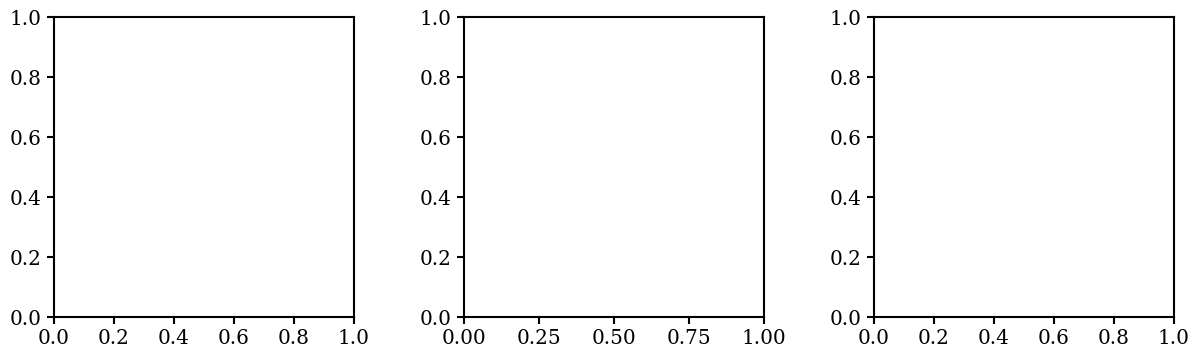

In [338]:
fig,ax = make_subplots(ncol = 3, nrow =1, return_fig=True)

plot_final_result(ax,cat, 0,alpha=0.5,linewidth=2,linestyle = "-",color = "r",scale_f = 2)

plt.show()

In [ ]:
bgs_cat[ff_mask]["RA","DEC"]

In [ ]:
##include an atlas of different galaxies in bins of different fracflux values




In [ ]:
## include the IZw18 galaxies



In [14]:
# #SOME VERY WEIRD STUFF IS HAPPENING HERE

# desi_nsa_match[desi_nsa_match["TARGETID"] == 39628394354183590]
# fp = "/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-110p025-120p030/1195p260/ELG_tgid_39628394354183590"
# tab = Table.read(fp + "/source_cat_f_more.fits")
# len(tab)
# plt.scatter(tab["ra"],tab["dec"])
# plt.xlim([ np.min(tab["ra"]),  np.max(tab["ra"]) ])
# plt.show()

In [692]:
# img_path = tot_shred[tot_shred["TARGETID"] == 39633038857996674]["IMAGE_PATH"][0]

In [688]:
maskbits = fits.open(img_path)[2].data
invvar = fits.open(img_path)[1].data
data = fits.open(img_path)[0].data


## Cross match with 50MGC and NSA

In [177]:
bgsb_shred = Table.read(f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_BRIGHT_shreds_catalog_w_aper_mags.fits")
bgsf_shred = Table.read(f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_BGS_FAINT_shreds_catalog_w_aper_mags.fits")
lowz_shred = Table.read(f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_LOWZ_shreds_catalog_w_aper_mags.fits")
elg_shred = Table.read(f"/pscratch/sd/v/virajvm/catalog_dr1_dwarfs/iron_photometry/iron_ELG_shreds_catalog_w_aper_mags.fits")

tot_shred = vstack([ bgsb_shred, bgsf_shred, lowz_shred, elg_shred ])

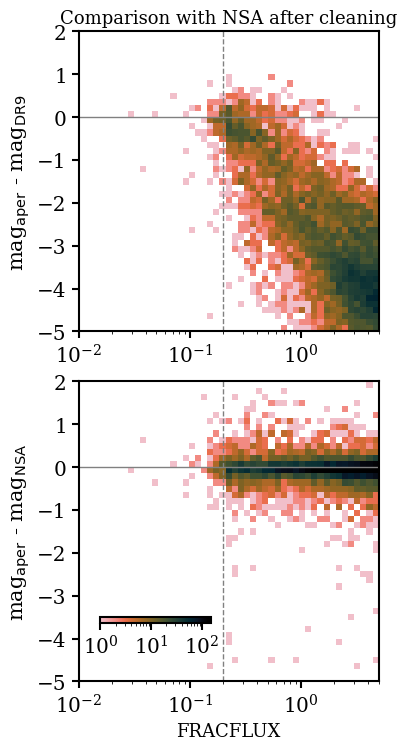

In [401]:
make_fracflux_compare_plot(nsa_ff, desi_match_mag_clean, nsa_trac_mag, nsa_mag_clean, title = "Comparison with NSA after cleaning",
                              ylab_top = r"mag$_{\rm aper}$ - mag$_{\rm DR9}$", ylab_bot=r"mag$_{\rm aper}$ - mag$_{\rm NSA}$", 
                           save_path = "plots/nsa_trac_ff_comp.png")


In [407]:
def plot_nsa(ax,nsa_cat,desi_cat,targetid, alpha=0.5,linewidth=2,linestyle = "-",color = "r",scale_f = 2):
    '''
    Function that plots the SGA ellipse and compares it with our reconstructed galaxy
    '''
    #get the mag info
    index = np.where(desi_cat["TARGETID"] == targetid)[0]
    
    g_org, r_org, z_org = desi_cat[index]["MAG_G"], desi_cat[index]["MAG_R"], desi_cat[index]["MAG_Z"]
    g_new, r_new, z_new = desi_cat[index]["MAG_G_APERTURE_COG"], desi_cat[index]["MAG_R_APERTURE_COG"], desi_cat[index]["MAG_Z_APERTURE_COG"]
    g_nsa, r_nsa, z_nsa = nsa_cat[index]["MAG_G_CORR"], nsa_cat[index]["MAG_R_CORR"], nsa_cat[index]["MAG_Z_CORR"]

    #get the reconstructed galaxy from aperture photometry method
    file_path = desi_cat[index]["FILE_PATH"][0] 
    # print(file_path)
    
    reconst = np.load(file_path + "/final_reconstruct_galaxy.npy")
    # reconst_img = sdss_rgb(reconst)

    ##get the tractor source model
    source_model = np.load(file_path + "/tractor_source_model.npy")
    # source_img = sdss_rgb(source_model)
    
    #get image and wcs infno
    img_path = desi_cat[index]["IMAGE_PATH"][0]
    hdus = fits.open(img_path)
    img_data = hdus[0].data
    wcs = WCS(fits.getheader( img_path))
    # rgb_img=sdss_rgb(img_data)
    
    ##get sga info
    nsa_ra=nsa_cat["RA"].data[index]
    nsa_dec=nsa_cat["DEC"].data[index]
    # nsa_sma = nsa_cat["SERSIC_TH50"].data[index]
    nsa_sma = nsa_cat["ELPETRO_TH90"].data[:,4][index]    
    nsa_pa = nsa_cat["ELPETRO_PHI"].data[index]
    nsa_ba = nsa_cat["ELPETRO_BA"].data[index]
    
    coord = SkyCoord(ra=nsa_ra*u.deg, dec=nsa_dec*u.deg)
    x_center, y_center,_ = wcs.all_world2pix(nsa_ra,nsa_dec,0,1)

    # Convert semi-major axis to pixels
    pixscale = 0.262

    major_axis_pixels = nsa_sma / pixscale # [pixels]
    minor_axis_pixels = nsa_ba * major_axis_pixels  # [pixels]
    plot_ellipse=True
    max_axis = int(np.minimum( scale_f * np.maximum(major_axis_pixels, minor_axis_pixels), np.shape(img_data)[1] ))
    max_axis = np.maximum(max_axis, 150)


    rgb_img, shift = process_img(img_data, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    source_img, _ = process_img(source_model, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    reconst_img, _ = process_img(reconst, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )

    #however, once we do the rescaling of image, we need to shift the x_center, y_center
    x_center -= shift
    y_center -= shift
    
    ax[0].imshow(source_img, origin="lower")

    fsize = 13
    fs_col = "white"
    yloc = 0.95
    ax[0].set_title("DESI Source Tractor Model",fontsize = fsize)
    #top show the grz magnitudes of these objects
    ax[0].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_org, r_org, z_org),size = fsize,
               transform=ax[0].transAxes, va='top',ha="center",color = fs_col)

    ax[0].set_ylabel(f"{targetid}",fontsize = 13)
    
    ax[1].imshow(reconst_img, origin="lower")
    ax[1].set_title("This Method Reconstruction",fontsize = fsize)
    ax[1].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_new, r_new, z_new),size = fsize,
               transform=ax[1].transAxes, va='top',ha="center",color = fs_col)
    
    #at bottom, show the RA,DEC of this cutout
    
    ax[2].imshow(rgb_img, origin='lower')
    ax[2].set_title(r"NSA, ELPETRO 90% Aperture ",fontsize = fsize)
    ax[2].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_nsa, r_nsa, z_nsa),size = fsize,
               transform=ax[2].transAxes, va='top',ha="center",color = fs_col)

    if plot_ellipse:
        ellipse_angle = nsa_pa - 90. # CCW from x-axis
        # Draw ellipses
        ell = Ellipse((x_center, y_center), major_axis_pixels, minor_axis_pixels, angle=ellipse_angle,
                      facecolor='none', edgecolor=color, lw=linewidth, ls=linestyle, alpha=alpha)
        ax[2].add_patch(ell)

    for axi in ax:
        axi.set_xticks([])
        axi.set_yticks([])

    #plot the horizontal bar plotting 30''
    fs=12
    bar_size = 30/0.262
    bar_start = 0.07*np.shape(rgb_img)[0]
    y_bar = 0.07*np.shape(rgb_img)[0]
    
    for i in range(3):
        ax[i].plot([bar_start, bar_start+bar_size], [y_bar,y_bar],color = "white",lw = 1)
        
    # ax[0].text( bar_start + 0.4*bar_size, y_bar*1.15, r"$30''$",fontsize = fs,color = "white"  )
            
    return ax
    
    


In [350]:
nsa_diff_inds = np.where( np.abs(nsa_delta_r) > 0.75)[0]
nsa_good_inds = np.where( np.abs(nsa_delta_r) < 0.1)[0]

# nsa_delta_r, desi_nsa_match_clean, nsa_match_clean

# print_radecs(desi_nsa_match[delta_r_nsa > 1],ra="RA",dec="DEC")

In [351]:
from tqdm.notebook import tqdm
output_dir = "/pscratch/sd/v/virajvm/trash/nsa_images"

all_files = []

for index in tqdm(nsa_diff_inds[:100]):
    fig,ax=make_subplots(ncol=3,nrow = 1, col_spacing = 0.05,return_fig=True)
    plt.suptitle(f"OBJECT INDEX = {index}, TARGETID = {desi_nsa_match_clean[index]['TARGETID']}",x=0.35,y=0.8)
    
    targetid = desi_nsa_match_clean["TARGETID"][index]
    
    plot_nsa(ax,nsa_match_clean,desi_nsa_match_clean,targetid,scale_f=6)
    
    outfile = os.path.join(output_dir, f"nsa_index_{index}.png")
    fig.savefig(outfile, bbox_inches="tight")
    all_files.append(outfile)
    plt.close(fig)

    
from desi_lowz_funcs import get_scrollable_pdfs

get_scrollable_pdfs(all_files, "/pscratch/sd/v/virajvm/trash/nsa_diff_match_VI.pdf")

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_1928453/3246679626.py:80: UserWarning: Warning: converting a masked element to nan.
  ax[2].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_nsa, r_nsa, z_nsa),size = fsize,


Scrollable pdf saved at /pscratch/sd/v/virajvm/trash/nsa_diff_match_VI.pdf


In [387]:
desi_nsa_match_clean[ desi_nsa_match_clean["TARGETID"] == 39627955982306238 ]["FILE_PATH"]

# 39627803485805800
# 

/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-140p005-150p010/1456p070/BGS_BRIGHT_tgid_39627955982306238


In [360]:
hdus = fits.open("/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds_cutouts/image_tgid_39627758254424586_ra_222.023_dec_-1.183.fits")
hdus

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7f6af53b8f70>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f6af585f670>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7f6af585d000>]

In [367]:
np.unique(hdus[2].data)

array([0, 1, 2, 3, 4, 5, 6], dtype=int32)

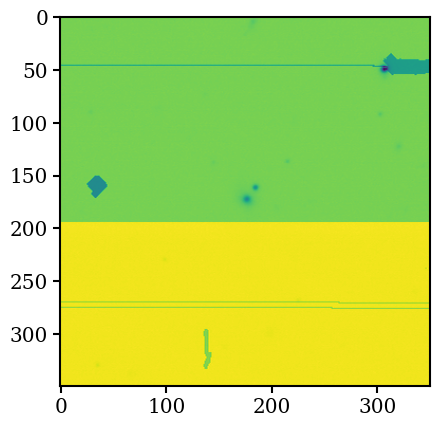

In [370]:

plt.imshow(hdus[1].data[2],norm=LogNorm())
plt.show()

In [405]:
nsa_us_agree = [39627403688938698, 39627782333924609, 39627480046242009, 39627788403081433, 39627593074347906,39627688041776907, 39627603434279953, 39627751577095177,  ]

nsa_worse_tgids = [39627739572997422, 39628502126824452, 39633006549273256, 39633153685455281, 39627889687135617, 39627740013401179,]

nsa_better_tgids = [39627824100806546, 39627703434871529, 39627709680192992, 39627740101478413 , 39627999485624747, 39628230541445186, 39628497034937568, 39633207930390671 ]

nsa_ambi = [39628001331119949, 39627793713071971 ]

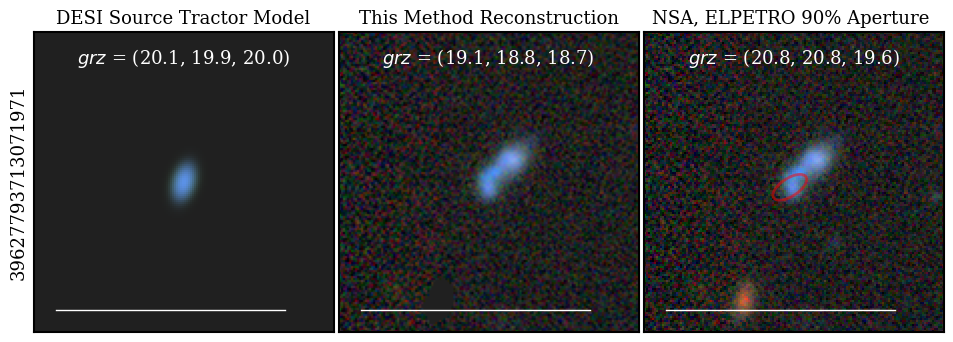

In [441]:
from tqdm.notebook import tqdm
output_dir = "/pscratch/sd/v/virajvm/trash/nsa_images"

targetid = nsa_ambi[1]

fig,ax=make_subplots(ncol=3,nrow = 1, col_spacing = 0.05,return_fig=True)
# plt.suptitle(f"OBJECT INDEX = {index}, TARGETID = {desi_nsa_match_clean[index]['TARGETID']}",x=0.35,y=0.8)

plot_nsa(ax,nsa_match_clean,desi_nsa_match_clean,targetid,scale_f=5)

outfile = os.path.join(output_dir, f"nsa_index_{targetid}.png")
fig.savefig(outfile, bbox_inches="tight")
plt.show()


In [2]:
def get_50mgc_Bmag(cat):

    cat_bmag = cat["BMag"].data

    cat_dist_pc = cat["bestdist"].data * 1e6
    
    cat_mag = cat_bmag + 5*np.log10( cat_dist_pc ) - 5

    return cat_mag

def get_50mgc_Imag(cat):
    '''
    In this function, we obtain the magnitudes we need for comparison.

    We convert the luminosities to magnotudes usign the zbest dist as described in te paper
    '''

    cat_lumis = cat["i_lum_nsa"].data

    #conver to absolute mag
    #the 4.53 value is mentioned in the column header
    cat_ab_mag = 4.53 - 2.5*np.log10(cat_lumis)

    cat_dist_pc = cat["bestdist"].data * 1e6
    
    cat_mag = cat_ab_mag + 5*np.log10( cat_dist_pc ) - 5

    return cat_mag

# mgc_i_mags = get_50mgc_mags(mgc_match)

In [3]:
mgc_data = Table.read("/global/homes/v/virajvm/galaxy_image_prior/paper_1/datasets/catalog_50MPC.fits")
# mgc_data_no_sga = mgc_data[(mgc_data["sga_obj"] == 0) & (mgc_data["nsa_obj"] == 1)]
#we want to make a comparison that is not in SGA 
print(len(mgc_data))
print(len(tot_shred_clean))

15424


NameError: name 'tot_shred_clean' is not defined

In [467]:
idx, d2d,_ = match_c_to_catalog(c_cat = mgc_data, catalog_cat = tot_shred_clean, c_ra="ra",c_dec="dec")

In [502]:
##as there is no radius information in the catalog, we simply adopt a 10 arcsec distance cutoff
mgc_match = mgc_data[d2d.arcsec < 20]
desi_match = tot_shred_clean[idx][d2d.arcsec < 20]

print(len(mgc_match))

145


In [503]:
mgc_match[:2]["BMag"]

-18.027058
-13.295779


In [504]:
bmags_mgc = get_50mgc_Bmag(mgc_match)

In [505]:
desi_Bmag = desi_match["MAG_G_APERTURE_COG"].data + 0.39*(desi_match["MAG_G_APERTURE_COG"].data - desi_match["MAG_R_APERTURE_COG"].data) + 0.21 

In [551]:
np.unique(mgc_match["mag_flag"] )
# 
# mgc_match

0
1
2


In [552]:
mgc_mask = (mgc_match["mag_flag"] != 0)

25
145


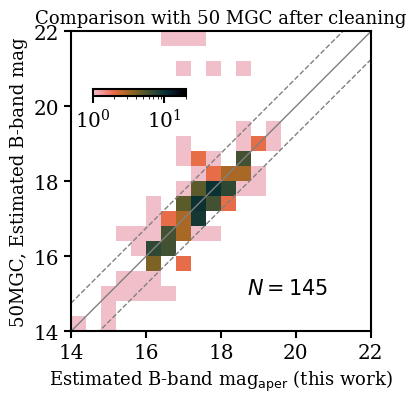

In [554]:
fig,ax = make_subplots(ncol = 1, nrow = 1,return_fig=True)

ax[0].set_title("Comparison with 50 MGC after cleaning",fontsize = 13)

im = ax[0].hist2d(desi_Bmag,bmags_mgc,range=((14,22), (14,22)),bins=20,norm=LogNorm(vmin=1,vmax=20), cmap = cmr.dusk_r, zorder = 0 )

ax[0].plot([14,22],[14,22],color = "grey",zorder=1,lw = 1)
ax[0].plot([14,22],[14-0.75,22-0.75],color = "grey",zorder=1, ls = "--",lw = 1)
ax[0].plot([14,22],[14+0.75,22+0.75],color = "grey",zorder=1,ls = "--",lw = 1)
ax[0].set_xlabel(r"Estimated B-band mag$_{\rm aper}$ (this work)",fontsize = 13)
ax[0].set_ylabel(r"50MGC, Estimated B-band mag",fontsize = 13)
ax[0].set_xlim([14,22])
ax[0].set_ylim([14,22])

delta_mag_mgc = bmags_mgc - desi_Bmag

print(len(delta_mag_mgc[np.abs(delta_mag_mgc) > 0.75]))
print(len(bmags_mgc))

cbar_ax = fig.add_axes([0.0775, 0.575, 0.055, 0.0125])  # top-left corner, horizontal bar
cbar = plt.colorbar(im[3], cax=cbar_ax, orientation='horizontal')
# cbar.ax.tick_params(labelsize=12)
    
# from scipy.stats import median_abs_deviation
# delta_nmad = median_abs_deviation(delta_mag,scale="normal")

# ax_bot.text(17.75,15.125,r"$\sigma_{\rm NMAD} = %.2f$"%delta_nmad,fontsize = 15)

ax[0].text(18.7,15,r"$N = %d$"%int(len(desi_Bmag)),fontsize = 15)
    
# plt.savefig("plots/mag_compare_50MGC.pdf",bbox_inches="tight")

# mgc_mask removes some objects, what is that flag?

plt.show()

In [515]:
desi_big_diffs = desi_match[np.abs(delta_mag_mgc) > 0.75]


In [539]:
def plot_50mgc(ax,desi_cat,mgc_match, index, alpha=0.5,linewidth=2,linestyle = "-"):
    '''
    Function that plots the SGA ellipse and compares it with our reconstructed galaxy
    '''
    
    g_org, r_org, z_org = desi_cat[index]["MAG_G"], desi_cat[index]["MAG_R"], desi_cat[index]["MAG_Z"]
    g_new, r_new, z_new = desi_cat[index]["MAG_G_APERTURE_COG"], desi_cat[index]["MAG_R_APERTURE_COG"], desi_cat[index]["MAG_Z_APERTURE_COG"]

    print("LOGM SAGA APERTURE COG = ", desi_cat[index]["LOGM_SAGA_APERTURE_COG"])
    print("50MGC Mstar = ", )

    # g_nsa, r_nsa, z_nsa = nsa_cat[index]["MAG_G_CORR"], nsa_cat[index]["MAG_R_CORR"], nsa_cat[index]["MAG_Z_CORR"]

    #get the reconstructed galaxy from aperture photometry method
    file_path = desi_cat[index]["FILE_PATH"]
    print(file_path)
    
    reconst = np.load(file_path + "/final_reconstruct_galaxy.npy")
    # reconst_img = sdss_rgb(reconst)

    ##get the tractor source model
    source_model = np.load(file_path + "/tractor_source_model.npy")
    # source_img = sdss_rgb(source_model)
    
    #get image and wcs infno
    img_path = desi_cat[index]["IMAGE_PATH"]
    hdus = fits.open(img_path)
    img_data = hdus[0].data
    wcs = WCS(fits.getheader( img_path))
    # rgb_img=sdss_rgb(img_data)

    max_axis = 400
    
    rgb_img, shift = process_img(img_data, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    source_img, _ = process_img(source_model, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )
    reconst_img, _ = process_img(reconst, cutout_size = max_axis, org_size = np.shape(img_data)[1], return_shift=True )

    ax[0].imshow(source_img, origin="lower")

    fsize = 13
    fs_col = "white"
    yloc = 0.95
    ax[0].set_title("DESI Source Tractor Model",fontsize = fsize)
    #top show the grz magnitudes of these objects
    ax[0].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_org, r_org, z_org),size = fsize,
               transform=ax[0].transAxes, va='top',ha="center",color = fs_col)

    ax[0].set_ylabel(f"{targetid}",fontsize = 13)
    
    ax[1].imshow(reconst_img, origin="lower")
    ax[1].set_title("This Method Reconstruction",fontsize = fsize)
    ax[1].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_new, r_new, z_new),size = fsize,
               transform=ax[1].transAxes, va='top',ha="center",color = fs_col)
    
    #at bottom, show the RA,DEC of this cutout
    
    ax[2].imshow(rgb_img, origin='lower')
    ax[2].set_title(r"$grz$ image",fontsize = fsize)
    ax[2].text(0.5,yloc,r"50 MGC $m_{\rm B}$ = %.1f"%(),size = fsize,
               transform=ax[2].transAxes, va='top',ha="center",color = fs_col)

    for axi in ax:
        axi.set_xticks([])
        axi.set_yticks([])

    #plot the horizontal bar plotting 30''
    fs=12
    bar_size = 30/0.262
    bar_start = 0.07*np.shape(rgb_img)[0]
    y_bar = 0.07*np.shape(rgb_img)[0]
    
    for i in range(3):
        ax[i].plot([bar_start, bar_start+bar_size], [y_bar,y_bar],color = "white",lw = 1)
        
    # ax[0].text( bar_start + 0.4*bar_size, y_bar*1.15, r"$30''$",fontsize = fs,color = "white"  )
            
    return ax
    
    


/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-120p030-130p035/1300p317/BGS_BRIGHT_tgid_39628516370679112


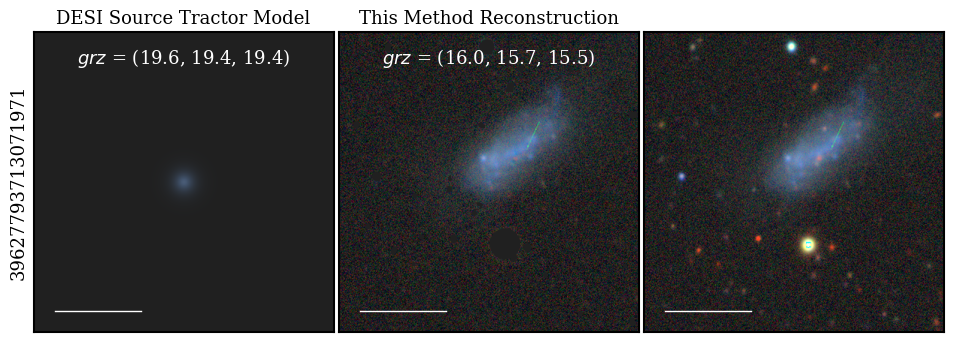

/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-190p000-200p005/1914p045/BGS_BRIGHT_tgid_39627896603545910


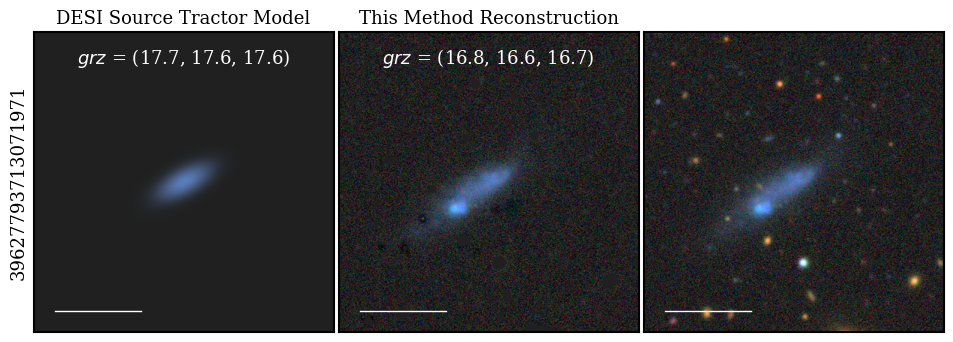

/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/north/sweep-120p070-130p075/1264p740/BGS_BRIGHT_tgid_39633519533621935


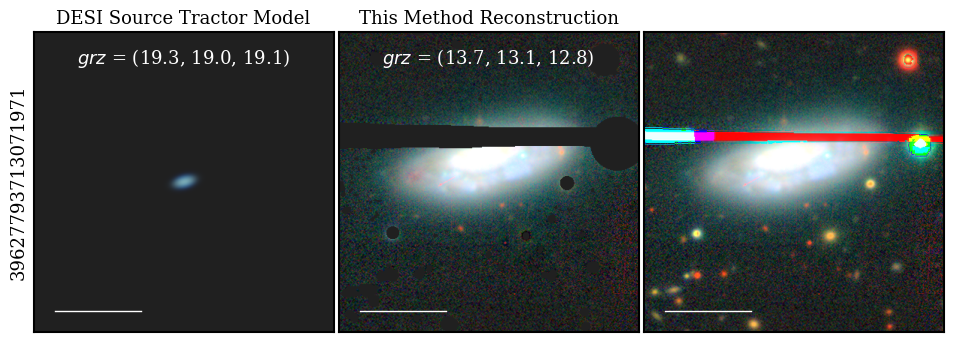

/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-140p010-150p015/1435p110/BGS_BRIGHT_tgid_39628051478219451


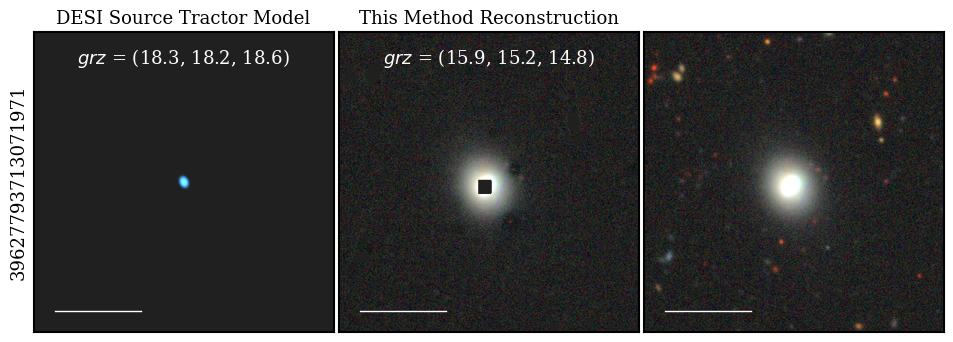

/pscratch/sd/v/virajvm/redo_photometry_plots/all_deshreds/south/sweep-160p005-170p010/1695p077/BGS_BRIGHT_tgid_39627974370132829


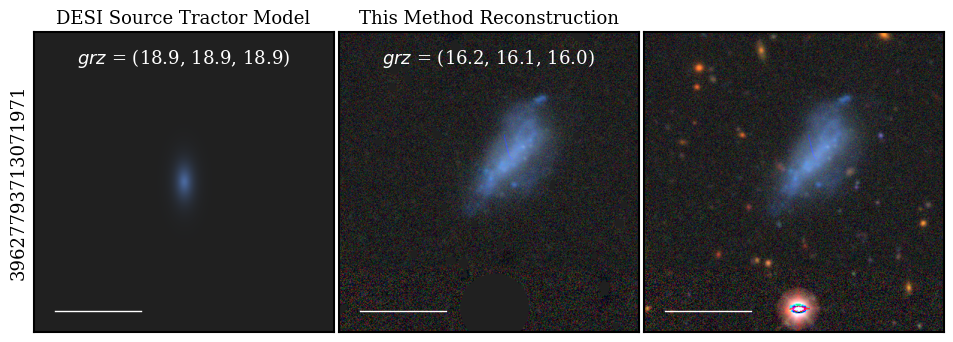

In [542]:

for index in range(len(desi_big_diffs[:5])):
    fig,ax = make_subplots(ncol=3,nrow = 1, col_spacing = 0.05,return_fig=True)
    plot_50mgc(ax,desi_big_diffs,index)
    plt.show()

  0%|          | 0/83 [00:00<?, ?it/s]

/tmp/ipykernel_731201/3246679626.py:80: UserWarning: Warning: converting a masked element to nan.
  ax[2].text(0.5,yloc,r"$grz$ = (%.1f, %.1f, %.1f)"%(g_nsa, r_nsa, z_nsa),size = fsize,


Scrollable pdf saved at /pscratch/sd/v/virajvm/trash/nsa_VI.pdf


TARGETID,SURVEY,PROGRAM,HEALPIX,SPGRPVAL,Z,ZERR,ZWARN,CHI2,COEFF,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,COADD_FIBERSTATUS,RA,DEC,PMRA,PMDEC,REF_EPOCH,FA_TARGET,FA_TYPE,OBJTYPE,SUBPRIORITY,OBSCONDITIONS,RELEASE,BRICKNAME,BRICKID,BRICK_OBJID,MORPHTYPE,EBV,FIBERFLUX_R,MASKBITS,REF_ID,REF_CAT,GAIA_PHOT_G_MEAN_MAG,GAIA_PHOT_BP_MEAN_MAG,GAIA_PHOT_RP_MEAN_MAG,PARALLAX,PHOTSYS,PRIORITY_INIT,NUMOBS_INIT,CMX_TARGET,DESI_TARGET,BGS_TARGET,MWS_TARGET,SCND_TARGET,SV1_DESI_TARGET,SV1_BGS_TARGET,SV1_MWS_TARGET,SV1_SCND_TARGET,SV2_DESI_TARGET,SV2_BGS_TARGET,SV2_MWS_TARGET,SV2_SCND_TARGET,SV3_DESI_TARGET,SV3_BGS_TARGET,SV3_MWS_TARGET,SV3_SCND_TARGET,PLATE_RA,PLATE_DEC,COADD_NUMEXP,COADD_EXPTIME,COADD_NUMNIGHT,COADD_NUMTILE,MEAN_DELTA_X,RMS_DELTA_X,MEAN_DELTA_Y,RMS_DELTA_Y,MEAN_PSF_TO_FIBER_SPECFLUX,MEAN_FIBER_RA,STD_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_DEC,MIN_MJD,MAX_MJD,MEAN_MJD,TSNR2_GPBDARK_B,TSNR2_ELG_B,TSNR2_GPBBRIGHT_B,TSNR2_LYA_B,TSNR2_BGS_B,TSNR2_GPBBACKUP_B,TSNR2_QSO_B,TSNR2_LRG_B,TSNR2_GPBDARK_R,TSNR2_ELG_R,TSNR2_GPBBRIGHT_R,TSNR2_LYA_R,TSNR2_BGS_R,TSNR2_GPBBACKUP_R,TSNR2_QSO_R,TSNR2_LRG_R,TSNR2_GPBDARK_Z,TSNR2_ELG_Z,TSNR2_GPBBRIGHT_Z,TSNR2_LYA_Z,TSNR2_BGS_Z,TSNR2_GPBBACKUP_Z,TSNR2_QSO_Z,TSNR2_LRG_Z,TSNR2_GPBDARK,TSNR2_ELG,TSNR2_GPBBRIGHT,TSNR2_LYA,TSNR2_BGS,TSNR2_GPBBACKUP,TSNR2_QSO,TSNR2_LRG,MAIN_NSPEC,MAIN_PRIMARY,SV_NSPEC,SV_PRIMARY,ZCAT_NSPEC,ZCAT_PRIMARY,DESINAME,FLUX_G,FLUX_IVAR_G,MAG_G,MAG_G_ERR,FLUX_R,FLUX_IVAR_R,MAG_R,MAG_R_ERR,FLUX_Z,FLUX_IVAR_Z,MAG_Z,MAG_Z_ERR,FIBERMAG_R,OBJID,SIGMA_G,FRACFLUX_G,RCHISQ_G,SIGMA_GOOD_G,SIGMA_R,FRACFLUX_R,RCHISQ_R,SIGMA_GOOD_R,SIGMA_Z,FRACFLUX_Z,RCHISQ_Z,SIGMA_GOOD_Z,SHAPE_R,SHAPE_R_ERR,MU_R,MU_R_ERR,SERSIC,SERSIC_IVAR,BA,TYPE,PHI,NOBS_G,NOBS_R,NOBS_Z,MW_TRANSMISSION_G,MW_TRANSMISSION_R,MW_TRANSMISSION_Z,HALPHA_FLUX_CG,HALPHA_FLUXERR_CG,HALPHA_EW_CG,HALPHA_EWERR_CG,MASS_CG,MASSERR_CG,LOGM_SAGA,LOGM_M24,SWEEP,is_south,STARFDIST,STARDIST_DEG,STARMAG,STAR_RADIUS_ARCSEC,STAR_RA,STAR_DEC,IMAGE_SIZE_PIX,SAMPLE,SGA_ID_MATCH,SGA_D26_NORM_DIST,SGA_DIST_DEG,IMAGE_PATH,FILE_PATH,NEAREST_STAR_NORM_DIST,NEAREST_STAR_MAX_MAG,MAG_G_APERTURE_R375,MAG_R_APERTURE_R375,MAG_Z_APERTURE_R375,SAVE_PATH,APER_SOURCE_ON_SEGMENT,IMAGE_FITS_PATH,LOGM_SAGA_APERTURE_R375,MAG_G_APERTURE_COG,MAG_R_APERTURE_COG,MAG_Z_APERTURE_COG,G_APERTURE_COG_CHI2,R_APERTURE_COG_CHI2,Z_APERTURE_COG_CHI2,G_APERTURE_COG_DOF,R_APERTURE_COG_DOF,Z_APERTURE_COG_DOF,MAG_G_APERTURE_R4,MAG_R_APERTURE_R4,MAG_Z_APERTURE_R4,MAG_G_APERTURE_COG_ERR,MAG_R_APERTURE_COG_ERR,MAG_Z_APERTURE_COG_ERR,MAG_G_APERTURE_COG_PARAMS,MAG_R_APERTURE_COG_PARAMS,MAG_Z_APERTURE_COG_PARAMS,MAG_G_APERTURE_COG_PARAMS_ERR,MAG_R_APERTURE_COG_PARAMS_ERR,MAG_Z_APERTURE_COG_PARAMS_ERR,LOGM_SAGA_APERTURE_COG
,,,,,,,,,,,,,,,,deg,deg,mas / yr,mas / yr,yr,,,,,,,,,,,mag,nanomaggy,,,,mag,mag,mag,mas,,,,,,,,,,,,,,,,,,,,,deg,deg,,s,,,mm,mm,mm,mm,,deg,arcsec,deg,arcsec,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,1/nanomaggy^2,nanomaggy,,nanomaggy,,,,nanomaggy,,,,nanomaggy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,bytes7,bytes6,int32,int32,float64,float64,int64,float64,float64[10],int64,bytes6,bytes20,int64,float64,int32,float64,float64,float32,float32,float32,int64,uint8,bytes3,float64,int32,int16,bytes8,int32,int32,bytes4,float32,float32,int16,int64,bytes2,float32,float32,float32,float32,bytes1,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int16,float32,int16,int16,float32,float32,float32,float32,float32,float64,float32,float64,float32,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,bool,int16,bool,int16,bool

In [438]:
# desi_nsa_match[delta_nsa < -1]['RA',"DEC","FILE_PATH"]

PETRO_BA50	float32		Axis ratio b/a from Stokes parameters at 50% light radius
PETRO_PHI50	float32	deg	Angle (E of N) from Stokes parameters at 50% light radius
PETRO_BA90	float32		Axis ratio b/a from Stokes parameters at 90% light radius
PETRO_PHI90	float32	deg	Angle (E of N) from Stokes parameters at 90% light radius

PETRO_FLUX	float32	nanomaggies	Azimuthally-averaged SDSS-style Petrosian flux in FNugriz (GALEX-SDSS photometric systems)

Are these magnitudes extinction corrected??

In [223]:
large_diff_cat = desi_match[ np.abs(desi_Bmag - bmags_mgc) > 2 ]

In [225]:
large_diff_cat["RA","DEC"]

RA,DEC
float64,float64
144.73877167314222,0.6972467881542959
201.5509121228654,37.766798568760116
211.96463147751078,50.901991631892315
223.65137757012192,48.668179126652056
244.09111224771266,34.95174028440917


In [141]:
# Based on this analysis, we created the
# mag flag column to signify which source provided the
# more accurate measurement at a given magnitude – 0:
# the difference between B and g are within one magnitude, so NSA values are used for calculating masses. 1:
# B and g are discrepant; NSA photometry is more reliable. 2: B and g are discrepant; HyperLeda photometry
# is more reliable, and is used for estimating masses.